In [1]:
import random
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import gym_minigrid
from gym_minigrid.minigrid import Wall, Door, Key, Ball, Box
from gym_minigrid.wrappers import *
from gym_minigrid.window import Window
from skimage.transform import resize

env = gym.make("MiniGrid-BlockedUnlockPickup-v0")


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# DISCOUNTED FACTOR
gamma = 0.95

# PARAMS GAME
num_episodes = 1000
buffer_size = 1000
mini_batch_size = 32
steps_per_target_update = 5
batch_size = 4

# PARAMS NEURAL NETWKORK
learning_rate = 0.001
cropped_state_size = [64, 128, 3]
state_size = [64, 128, 1]
num_input_neurons = state_size[0]
num_ouptut_neurons = env.action_space.n
common_net_hidden_dimensions = [16, 64]

# Rewards engineering
rewards_carring = {Key: 0.0, Ball:0.0}
rewards_door = {'is_locked':-0.1, 'is_open':50}
rewards_box = {'contains_ball': 100, 'contains_key':-50}

# For saving in csv file the rewards
import pandas as pd
raw_data = {'episode_number':[], 'total_reward':[]}

In [3]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [4]:
def getGoalDoorBoxPos(env_grid):
    goal_pos = 0
    door_pos = 0
    ball_pos = 0
    for i in range(len(env_grid)):
        if type(env_grid[i]) == Box:
            goal_pos = i
        if type(env_grid[i]) == Door:
            door_pos = i
        if type(env_grid[i]) == Ball:
            ball_pos = i
    return goal_pos, door_pos, ball_pos

In [5]:
def getReward(goal_pos, door_pos, ball_pos, env):
    env_grid = env.grid.grid
    reward = 0
    ## Rewards for carrying
    if type(env.carrying) == Ball:
        reward += rewards_carring[Ball]
    elif type(env.carrying) == Key:
        reward += rewards_carring[Key]
    ## Rewards for door opening
    if env_grid[door_pos].is_locked:
        reward += rewards_door['is_locked']
    elif env_grid[door_pos].is_open:
        reward += rewards_door['is_open']
    ## Rewards for goal
    if type(env_grid[goal_pos].contains) == Ball:
        reward += rewards_box['contains_ball']
    elif type(env_grid[goal_pos].contains) == Key:
        reward += rewards_box['contains_key']
    
    return reward

In [6]:
def preprocess_frame(frame):
    # Crop the screen (remove part that contains no information)
    # [Up: Down, Left: right]
    cropped_frame = frame[36:-36, 36:-36]

    rgb = resize(cropped_frame, cropped_state_size)
    
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b  # extract luminance

    o = gray.astype('float32') / 128 - 1  # normalize
    o = o.reshape(*o.shape, 1)

    #pred_img = array_to_img(o)
    #pred_img.save('models/output.jpg')
    return o

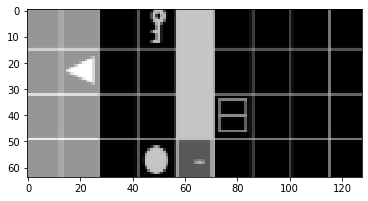

In [7]:
plt.imshow(np.squeeze(preprocess_frame(env.render(mode='rgb_array'))), cmap='gray')

In [8]:
class DDQN:
    def __init__(self,
                 session,
                 scope_name,
                 input_size,
                 hidden_layer_sizes,
                 output_size,
                 learning_rate,
                 state_size):

        self.session = session
        self.scope_name = scope_name
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate

        with tf.variable_scope(self.scope_name, reuse=tf.AUTO_REUSE):
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")

            # Input is 100x120x1
            self.conv1 = tf.layers.conv2d(inputs=self.inputs_,
                                          filters=32,
                                          kernel_size=[8, 8],
                                          strides=[4, 4],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name="conv1",
                                          )

            self.conv1_out = tf.nn.relu(self.conv1, name="conv1_out")

            """
            Second convnet: CNN RELU
            """
            self.conv2 = tf.layers.conv2d(inputs=self.conv1_out,
                                          filters=64,
                                          kernel_size=[4, 4],
                                          strides=[2, 2],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name="conv2")

            self.conv2_out = tf.nn.relu(self.conv2, name="conv2_out")

            """
            Third convnet: CNN RELU
            """
            self.conv3 = tf.layers.conv2d(inputs=self.conv2_out,
                                          filters=128,
                                          kernel_size=[4, 4],
                                          strides=[2, 2],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name="conv3")

            self.conv3_out = tf.nn.relu(self.conv3, name="conv3_out")

            self.flatten = tf.layers.flatten(self.conv3_out)

            # Separating streams into advantage and value networks
            adv_net = tf.layers.dense(self.flatten, 32, activation=tf.nn.relu)
            adv_net = tf.layers.dense(adv_net, self.output_size)

            val_net = tf.layers.dense(self.flatten, 32, activation=tf.nn.relu)
            val_net = tf.layers.dense(val_net, 1)

            self.output = val_net + (adv_net - tf.reduce_mean(adv_net,
                                                              reduction_indices=1,
                                                              keepdims=True))

            # Loss operations definition
            self.yt_loss = tf.placeholder(tf.float32, shape=(None)) # Getting from target
            
            self.actions = tf.placeholder(tf.int32, shape=(None))
            self.actions_onehot = tf.one_hot(self.actions, self.output_size, dtype=tf.float32)
            
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_onehot), reduction_indices=1)
        
            self.td_error = tf.square(self.yt_loss - self.Q)
            self.loss = tf.reduce_mean(self.td_error)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=self.learning_rate).minimize(self.loss)

    def predict(self, state):
        return self.session.run(self.output,
                                feed_dict={self.inputs_: state})

    def update(self, state, y, actions):
        return self.session.run([self.loss, self.optimizer],
                                feed_dict={
                                    self.inputs_: state,
                                    self.yt_loss: y,
                                    self.actions: actions
                                })

In [9]:
def train_dqn(main_dqn, mini_batch):
    """
    param: mini_batch: From the randomly sampled minbatch from replay-buffer,
                       it's a list of experiences in the form of
                       `(state, action, reward, next_state, done)`
    """
    states = np.array([x[0] for x in mini_batch])

    actions = np.array([x[1] for x in mini_batch])
    rewards = np.array([x[2] for x in mini_batch])
    next_states = np.array([x[3] for x in mini_batch])
    done = np.array([x[4] for x in mini_batch])

    # For double DQN: select the best action for next state
    Qs_batch = []

    # Get Q values for next_state
    main_output = main_dqn.predict(next_states)
    
    # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma * Qtarget(s',a')
    for i in range(0, mini_batch_size):
        terminal = done[i]

        # We got a'
        action = np.argmax(main_output[i])

        # If we are in a terminal state, only equals reward
        if terminal:
            Qs_batch.append(rewards[i])

        else:
            # Take the Q for action a'
            q = rewards[i] + gamma * main_output[i][action]
            Qs_batch.append(q)

    Qs = np.array([each for each in Qs_batch])
    
    loss, optimizer = main_dqn.update(states, Qs, actions)

    return loss

In [10]:
tf.reset_default_graph()

replay_buffer = deque(maxlen=buffer_size)
last_n_rewards = deque(maxlen=num_episodes)
rewards = deque(maxlen=num_episodes)
losses = deque(maxlen=num_episodes)

In [11]:
with tf.Session() as sess:
    main_dqn = DDQN(session=sess,
                     scope_name="q_main",
                     input_size=num_input_neurons,
                     hidden_layer_sizes=common_net_hidden_dimensions,
                     output_size=num_ouptut_neurons,
                     learning_rate=learning_rate,
                     state_size=state_size)

    # Saver will help us to save our model
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    # Load the model
    #saver.restore(sess, tf.train.latest_checkpoint('models'))

    # Some counter for training cycle
    counter = 1
    steps = np.zeros(num_episodes)

    try:
        for ep_num in range(0,num_episodes):
            env.reset()
            
            done = False
            episode_reward, loss = 0, 0
            episode_loss = []

            # epsilon decay
            epsilon = 1. / (ep_num + 1)

            while not done:
                state = preprocess_frame(env.render(mode='rgb_array'))
                # select the action
                action = None
                if np.random.rand() < epsilon:
                    action = random.randint(0, env.action_space.n-1)
                else:                    
                    action = np.argmax(main_dqn.predict(state.reshape((1, *state.shape))))

                # execute the action
                obs, reward, done, info = env.step(action)
                next_state = preprocess_frame(env.render(mode='rgb_array'))
                
                goal_pos, door_pos, ball_pos = getGoalDoorBoxPos(env.grid.grid)
                reward = getReward(goal_pos, door_pos, ball_pos, env)
                
                # add to the buffer
                replay_buffer.append((state, action, reward, next_state, done))

                # sample from the buffer and train
                if counter > mini_batch_size:
                    mini_batch = random.sample(replay_buffer, (mini_batch_size))
                    loss = train_dqn(main_dqn, mini_batch)
                    episode_loss.append(loss)
                    
                if done:
                    print(reward, steps[ep_num])
                    print("Door locked:", str(env.grid.grid[door_pos].is_locked))
                    print("Box contains ball:", str(type(env.grid.grid[goal_pos].contains)))

                counter +=1
                episode_reward += reward
                steps[ep_num] += 1
                state = next_state
                #print("Ep number: ", ep_num, " Action reward: ", reward, " Total reward: ", episode_reward, "Action: ", action)
            print("Episode number: ", ep_num, " with total reward: ", episode_reward)
            print("Loss: ", np.mean(episode_loss))

            last_n_rewards.append(episode_reward)
            last_n_avg_reward = np.mean(last_n_rewards)
            rewards.append(episode_reward)
            losses.append(np.mean(episode_loss))

            # Save model every 5 episodes
            if ep_num % 5 == 0:
                save_path = saver.save(sess, "models/model.ckpt")
                print("Model Saved")
                # Saving results into csv
                raw_data['episode_number'] = np.array(rewards)
                raw_data['total_reward'] = np.arange(len(rewards))
                df = pd.DataFrame(raw_data, columns=raw_data.keys())
                if not os.path.exists("results.csv"):
                    df.to_csv("results.csv", sep="\t")
                else:
                    df_old = pd.read_csv("results.csv", sep = ";")
                    df = df.append(df_old, ignore_index=True)
    except KeyboardInterrupt:
        print("SIGINT interception")
        save_path = saver.save(sess, "models/model.ckpt")
        print("Model Saved")
        # Saving results into csv
        raw_data['episode_number'] = np.array(rewards)
        raw_data['total_reward'] = np.arange(len(rewards))
        df = pd.DataFrame(raw_data, columns=raw_data.keys())
        if not os.path.exists("results.csv"):
            df.to_csv("results.csv", sep="\t")
        else:
            df_old = pd.read_csv("results.csv", sep = ";")
            df = df.append(df_old, ignore_index=True)
        pass



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
-0.1 575.0
Door locked: True
Box contains ball: <class 'NoneType'>
Episode number:  0  with total reward:  -57.60000000000055
Loss:  0.00018105694
Model Saved
-0.1 575.0
Door locked: True
Box contains ball: <class 'NoneType'>
Episode number:  1  with total reward:  -57.60000000000055
Loss:  0.0039255265
-0.1 575.0
Door locked: True

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


SIGINT interception
Model Saved


In [12]:
with tf.Session() as sess:
    main_dqn = DDQN(session=sess,
                     scope_name="q_main",
                     input_size=num_input_neurons,
                     hidden_layer_sizes=common_net_hidden_dimensions,
                     output_size=num_ouptut_neurons,
                     learning_rate=learning_rate,
                     state_size=state_size)

    # Saver will help us to save our model
    saver = tf.train.Saver()
    # Load the model
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    try:
        done = False
        env.reset()
        while not done:
            state = preprocess_frame(env.render(mode='rgb_array'))
            plt.imshow(np.squeeze(state))
            action = np.argmax(main_dqn.predict(state.reshape((1, *state.shape))))
            print(action)

            # execute the action
            obs, reward, done, info = env.step(action)
            
    except KeyboardInterrupt:
        print("SIGINT interception")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/model.ckpt


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1356, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.NotFoundError: Key q_main_1/beta1_power not found in checkpoint
	 [[{{node save_1/RestoreV2}}]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/training/saver.py", line 1286, in restore
    {self.saver_def.filename_tensor_name: save_path})
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 950, in run
    run_metadata_ptr)
  F

TypeError: can only concatenate str (not "list") to str